The following analysis aims to understand the impact of failures of active bakers to timely upgrade to the Cathage protocol version on Tezos network. 
Further, the analysis provides a detailed view on the upgrade readiness among active validators. 

We applied the following assumptions to the analysis:
Bakers that failed to endorse more than two slots and did not recover from the failure within two hours of the upgrade were considered as impacted by the upgrade.
Validators who had an average reliability of the four cycles before the upgrade 
less than 20% were excluded from the analysis of impacted bakers. 
Active bakers were calculated as the total of bakers who had rights in thea cycle immediately after the upgrade (cycle 208)
The analysis only considered data for the four cycles before the upgrade and five cycles after the upgrade.  

In [945]:
import requests
import json
import datetime

print('start')
# Function to convert datetime in milliseconds to human readable format
def convert_from_ms( milliseconds ): 
    seconds, milliseconds = divmod(milliseconds,1000) 
    minutes, seconds = divmod(seconds, 60) 
    hours, minutes = divmod(minutes, 60) 
    days, hours = divmod(hours, 24) 
    seconds = seconds + milliseconds/1000 
    return round(((days*24*60+hours*60+minutes)/60),2)

# Upgrade cycle parameters 
cycle_upgrade = 208
cycle_before_upgrade_range = [
    cycle_upgrade-4,
    cycle_upgrade-3,
    cycle_upgrade-2,
    cycle_upgrade-1
    ]
cycle_rights_upgrade_range = [
    cycle_upgrade,
    cycle_upgrade+1,
    cycle_upgrade+2,
    cycle_upgrade+3,
    cycle_upgrade+4,
    ]
cycle_upgrade_range = [
    cycle_upgrade-4,
    cycle_upgrade-3,
    cycle_upgrade-2,
    cycle_upgrade-1,
    cycle_upgrade,
    cycle_upgrade+1,
    cycle_upgrade+2,
    cycle_upgrade+3,
    cycle_upgrade+4
    ]

# Get upgrade block start height and datetime and end block height, timedate
cycle_json = requests.get("https://api.tzstats.com/explorer/cycle/%s" % cycle_upgrade)
cycle = cycle_json.json()
cycle_start_height = cycle.get("start_height")
cycle_start_datetime = cycle.get("start_time")
cycle_active_bakers = cycle.get("active_bakers")
cycle_start_datetime = datetime.datetime.strptime(cycle_start_datetime, '%Y-%m-%dT%H:%M:%fZ')
cycle_start_datetime = int((cycle_start_datetime - datetime.datetime(1970, 1, 1)).total_seconds()*1000)

income_dict = {}
# Call Income table API to retrieve metrics per cycle per baker
for cycle_income in cycle_upgrade_range:
    income_json = requests.get("https://api.tzstats.com/tables/income?&columns=cycle,address,row_id,rolls,n_delegations,contribution_percent,n_blocks_baked,n_blocks_lost,n_slots_endorsed,n_slots_missed,fees_income,n_baking_rights,n_endorsing_rights,balance,delegated,missed_baking_income,missed_endorsing_income&cycle=%s" % cycle_income)
    income = income_json.json()
    for baker in income:
        if baker[1] not in income_dict:
            income_dict[baker[1]]={}
        income_dict[baker[1]][int(baker[0])]={
            "rolls":baker[3],
            "n_delegations":baker[4],
            "contribution_percent":baker[5],
            "n_blocks_baked":baker[6],
            "n_blocks_lost":baker[7],
            "n_slots_endorsed":baker[8],
            "n_slots_missed":baker[9],
            "fees_income":baker[10],
            "n_baking_rights":baker[11],
            "n_endorsing_rights":baker[12],
            "baker_balance":baker[13], #A baker’s own balance, composed of spendable balance and frozen deposits plus frozen fees (at snapshot block). Note that frozen rewards do not contribute towards rolls, hence they are not part of balance here.
            "delegated_balance":baker[14], #Delegated balance (at snapshot block).
            "missed_baking_income":baker[15],
            "missed_endorsing_income":baker[16]
            }


baker_dict = {}
# Call Rigths API to retrive blocks stats within selected cycle
for cycle in cycle_rights_upgrade_range:
    rights_json = requests.get("https://api.tzstats.com/tables/rights?cycle=%s&type=endorsing&columns=address,height,is_missed,time,priority,cycle,type,row_id&limit=500000" %cycle)
    rights = rights_json.json()
    height= cycle_start_height, rights[3]
    for right in rights:
        if right[0] not in baker_dict:
            baker_dict[right[0]] = {}
        if int(right[1]) not in baker_dict[right[0]]:
            baker_dict[right[0]][int(right[1])] = {}
        baker_dict[right[0]][int(right[1])][right[4]] = {
            "cycle":right[5],
            "success":(True if right[2] == 0 else False),
            "datetime":right[3]}

total_endorsements ={baker_k: 
    {'total_blocks_endorsed':len(baker_v), 
    'total_slots_endorsed':sum([ len(slot.keys()) 
    for slot in baker_v.values()])} 
    for (baker_k,baker_v) in baker_dict.items()
    }

# Create a dictionary for baker realiability per cycle
cycle_reliability_upgrade = {
    baker_k: {
        cycle_k: cycle_v['contribution_percent'] for cycle_k, cycle_v in baker_v.items()
        } for baker_k,baker_v in income_dict.items()}
cycle_reliability_upgrade = { k:v for k,v in cycle_reliability_upgrade.items() if v != {}}

# Calculate average reliability per baker for the three cycles immediately before the upgrade cycle
cycle_reliability_before_upgrade_dict = {}
for baker_key, baker_val in cycle_reliability_upgrade.items():
    contributions_before_upgrade = [ baker_val[cycle_before_upgrade] for cycle_before_upgrade in cycle_before_upgrade_range if cycle_before_upgrade in baker_val and income_dict[baker_key][cycle_before_upgrade]['n_baking_rights']+income_dict[baker_key][cycle_before_upgrade]['n_endorsing_rights']!=0]
    if len(contributions_before_upgrade)>0:
        average_contribution_before_upgrade = round(sum(contributions_before_upgrade) / len(contributions_before_upgrade),2)
        if average_contribution_before_upgrade > 20:
            cycle_reliability_before_upgrade_dict[baker_key] = average_contribution_before_upgrade


#Calculate average reliability per baker for the three cycles immediately before the upgrade cycle
cycle_reliability_after_upgrade_dict = {}
cycle_after_upgrade_range = cycle_rights_upgrade_range
del cycle_after_upgrade_range[0]
for baker_key, baker_val in cycle_reliability_upgrade.items():
    contributions_after_upgrade = [ baker_val[cycle_after_upgrade] for cycle_after_upgrade in cycle_after_upgrade_range if cycle_after_upgrade in baker_val]
    if len(contributions_after_upgrade)>0:
        average_contribution_after_upgrade = round(sum(contributions_after_upgrade) / len(contributions_after_upgrade),2)
    else:
        average_contribution_after_upgrade = 0.0
    cycle_reliability_after_upgrade_dict[baker_key] = average_contribution_after_upgrade

print('end part 1')

start
end part 1


In [946]:
#Get private vs public attribute for bakers
account_json = requests.get("https://api.tzkt.io/v1/delegates/?select=address,alias,balance&limit=10000")
is_baker_public ={account['address']:(account['alias'] != None) for account in account_json.json()}

In [987]:
print('start')
# Populate upgrade reliability results per baker in a separate dictionary
upgrade_results = {}
count_bakers_more_than_cycle_to_fix = 0
for baker_key in cycle_reliability_before_upgrade_dict.keys():
    if baker_key in baker_dict:
        baker_val = baker_dict[baker_key]
        time_first_success = 0
        first_success = 0
        upgrade_failures = 0  
        for height in sorted(baker_val.keys()):
# bakers who failed to bake the first block after the upgrade
            if next(iter(baker_val[height].values()))['success']==True:
                time_first_success = next(iter(baker_val[height].values()))["datetime"]
                first_success = height
                break
            else:
                upgrade_failures += 1
                max_failure = height
                time_last_failure = next(iter(baker_val[max_failure].values()))["datetime"]
        if upgrade_failures > 1:
            time_to_fix = convert_from_ms(time_first_success - cycle_start_datetime)
            time_to_fix_days = round(time_to_fix/24)
            upgrade_results[baker_key] = {
                'public':is_baker_public[baker_key],
                'rolls_upgrade_cycle':income_dict[baker_key][cycle_upgrade]['rolls'],
                'baker_balance':income_dict[baker_key][cycle_upgrade]['baker_balance'],
                'delegated_balance':income_dict[baker_key][cycle_upgrade]['delegated_balance'],
                'delegations_upgrade_cycle':income_dict[baker_key][cycle_upgrade]['n_delegations'],
                'avg_contribution_before_upgrade':cycle_reliability_before_upgrade_dict[baker_key],
                'n_rights_upgrade_cycle':(income_dict[baker_key][cycle_upgrade]['n_baking_rights']+income_dict[baker_key][cycle_upgrade]['n_endorsing_rights']),
                'contribution_upgrade_cycle':( cycle_reliability_upgrade[baker_key][cycle_upgrade] if income_dict[baker_key][cycle_upgrade]['n_baking_rights']+income_dict[baker_key][cycle_upgrade]['n_endorsing_rights']!=0 else 0),
                'avg_contribution_after_upgrade':cycle_reliability_after_upgrade_dict[baker_key],
                'n_slots_missed_due_to_upgrade_issues':upgrade_failures, #after the upgrade until the first successful bake or until the end of upgrade_cycle+4
                'total_slots_endorsed':total_endorsements[baker_key]['total_slots_endorsed'], #in upgrade cycle and 4 cycles after the upgrade
                'total_blocks_endorsed':total_endorsements[baker_key]['total_blocks_endorsed'], #in upgrade cycle and 4 cycles after the upgrade
                'last_block_failed_to_endorse':max_failure, 
                'first_successful_block':first_success, 
                'time_to_fix_hours':time_to_fix,
                'time_to_fix_days':time_to_fix_days
                }


start


In [988]:
print('start')
upgrade_results_pn = {'address':[],
                      'public':[],
                      'rolls_upgrade_cycle':[],
                      'baker_balance':[],
                      'delegated_balance':[], 
                      'delegations_upgrade_cycle':[],
                      'n_rights_upgrade_cycle':[],
                      'avg_contribution_before_upgrade':[],
                      'contribution_upgrade_cycle':[],
                      'avg_contribution_after_upgrade':[],
                      'n_slots_missed_due_to_upgrade_issues':[],
                      'total_slots':[],
                      'total_blocks':[],
                      'last_block_failed_to_endorse':[],
                      'first_successful_block':[],
                      'time_to_fix_hours':[],
                      'time_to_fix_days':[]
                       }
# Populate upgrade reliability results per baker in a separate dictionary
for k,v in upgrade_results.items():
    days = v['time_to_fix_hours']/24
    days = round(days)
    upgrade_results_pn['address'].append(k)
    upgrade_results_pn['public'].append(v['public'])
    upgrade_results_pn['rolls_upgrade_cycle'].append(v['rolls_upgrade_cycle'])
    upgrade_results_pn['baker_balance'].append(v['baker_balance'])
    upgrade_results_pn['delegated_balance'].append(v['delegated_balance'])
    upgrade_results_pn['delegations_upgrade_cycle'].append(v['delegations_upgrade_cycle'])
    upgrade_results_pn['n_rights_upgrade_cycle'].append(v['n_rights_upgrade_cycle'])
    upgrade_results_pn['avg_contribution_before_upgrade'].append(v['avg_contribution_before_upgrade'])
    upgrade_results_pn['contribution_upgrade_cycle'].append(v['contribution_upgrade_cycle'])    
    upgrade_results_pn['avg_contribution_after_upgrade'].append(v['avg_contribution_after_upgrade'])
    upgrade_results_pn['n_slots_missed_due_to_upgrade_issues'].append(v['n_slots_missed_due_to_upgrade_issues'])
    upgrade_results_pn['total_slots'].append(v['total_slots_endorsed'])
    upgrade_results_pn['total_blocks'].append(v['total_blocks_endorsed'])
    upgrade_results_pn['last_block_failed_to_endorse'].append(v['last_block_failed_to_endorse'])
    upgrade_results_pn['first_successful_block'].append(v['first_successful_block'])
    upgrade_results_pn['time_to_fix_hours'].append(v['time_to_fix_hours'])
    upgrade_results_pn['time_to_fix_days'].append(days)

start


In [989]:
bakers_fixed_within_5cycles_public = {
                    'rolls_upgrade_cycle':[],
                    'time_to_fix_hours':[],
                    'time_to_fix_days':[]
                    }
for k,v in upgrade_results.items():
    if  v['time_to_fix_hours']>2 and v['n_slots_missed_due_to_upgrade_issues']>2 and v['public']==True:
        bakers_fixed_within_5cycles_public['rolls_upgrade_cycle'].append(v['rolls_upgrade_cycle'])
        bakers_fixed_within_5cycles_public['time_to_fix_hours'].append(v['time_to_fix_hours']) 
        bakers_fixed_within_5cycles_public['time_to_fix_days'].append(v['time_to_fix_days']) 
print(bakers_fixed_within_5cycles_public)

bakers_fixed_within_5cycles_private = {
                    'rolls_upgrade_cycle':[],
                    'time_to_fix_hours':[],
                    'time_to_fix_days':[]
                    }
for k,v in upgrade_results.items():
    if  v['time_to_fix_hours']>2  and v['n_slots_missed_due_to_upgrade_issues']>2 and v['public']==False:
        bakers_fixed_within_5cycles_private['rolls_upgrade_cycle'].append(v['rolls_upgrade_cycle'])
        bakers_fixed_within_5cycles_private['time_to_fix_hours'].append(v['time_to_fix_hours']) 
        bakers_fixed_within_5cycles_private['time_to_fix_days'].append(v['time_to_fix_days']) 
print(bakers_fixed_within_5cycles_private)

{'rolls_upgrade_cycle': [131, 189, 67, 216, 10, 79, 3, 874, 262, 7, 84, 92, 991, 843, 71, 29, 50, 536, 108, 20, 1, 58, 1, 962, 26, 11, 657, 81, 5], 'time_to_fix_hours': [11.98, 6.17, 5.08, 15.35, 8.77, 24.72, 141.38, 4.05, 3.95, 55.95, 12.45, 3.5, 2.27, 27.57, 7.03, 8.32, 29.18, 3.28, 13.88, 16.45, 250.63, 8.42, 180.57, 2.55, 9.97, 291.28, 4.83, 3.63, 88.38], 'time_to_fix_days': [0, 0, 0, 1, 0, 1, 6, 0, 0, 2, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 10, 0, 8, 0, 0, 12, 0, 0, 4]}
{'rolls_upgrade_cycle': [15, 2, 15, 14, 22, 16, 170, 32, 545, 9, 40, 36, 8, 162, 4, 5, 44, 14, 12, 13, 18, 2, 16, 1, 8, 28, 164, 2, 5, 3, 1, 5, 33, 13, 41, 11, 13, 6, 190, 367, 56, 1, 3, 1, 2, 110, 29, 34, 7, 12, 6], 'time_to_fix_hours': [284.53, 99.98, 88.22, 343.2, 18.33, 15.15, 5.0, 21.75, 350.33, 188.3, 15.22, 272.5, 40.33, 213.62, 74.65, 50.63, 11.05, 143.95, 276.65, 24.08, 9.98, 166.2, 41.55, 281.48, 28.13, 15.73, 4.62, 97.85, 172.6, 156.62, 200.92, 163.13, 109.63, 5.78, 35.85, 17.15, 10.3, 76.67, 13.28, 178.32, 7.0

Reliability comparison before, during and after the upgrade

In [977]:
import pandas as pd
upgrade_results_table = pd.DataFrame(upgrade_results_pn)
bakers_fixed_within_5cycles_public_df = pd.DataFrame(bakers_fixed_within_5cycles_public)
bakers_fixed_within_5cycles_private_df = pd.DataFrame(bakers_fixed_within_5cycles_private)

In [978]:
%matplotlib inline

In [979]:
pd.set_option("display.max.columns", None)

In [1383]:
upgrade_results_table.head(129)

,address,public,rolls_upgrade_cycle,baker_balance,delegated_balance,delegations_upgrade_cycle,n_rights_upgrade_cycle,avg_contribution_before_upgrade,contribution_upgrade_cycle,avg_contribution_after_upgrade,n_slots_missed_due_to_upgrade_issues,total_slots,total_blocks,last_block_failed_to_endorse,first_successful_block,time_to_fix_hours,time_to_fix_days
0,tz1UUgPwikRHW1mEyVZfGYy6QaxrY6Y7WaG5,True,131,560771.079158,494431.117076,126,189,98.28,69.85,100.00,30,1030,1006,852597,852632,11.98,0
1,tz1SxEdtfkFChtqioi96hvMfisj4mt744rXi,False,15,22876.796104,97299.964343,36,16,100.00,0.00,25.00,96,120,120,868185,868493,284.53,12
2,tz1bAnevrEmqQZLU1k8AwVLpRsdGykCAvjuy,False,3,30847.645301,0.000000,0,7,95.84,71.43,100.00,2,19,19,852234,852908,16.77,1
3,tz1Ki7XLqA31ZXNHucXBAAwWk7pzLbeWjapM,False,2,16953.001506,4530.821854,3,3,106.25,0.00,85.00,6,14,14,857638,857719,99.98,4
4,tz1LUZNxLonRmotkLszDcNQLBMkMj42x7DdY,False,15,67598.423355,60097.661406,8,26,99.24,0.00,94.57,30,111,111,856887,857034,88.22,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118,tz1NhDkBjrAae3M92KS31psecRXM3F67tkGN,False,1,8000.012553,0.000000,0,0,75.00,0.00,50.00,3,3,3,871487,0,-439828.68,18
119,tz1TYjqdDEwMvkv7o3jNjYhYqmEnkxVH6tsJ,False,1,2010.004086,6288.288756,2,2,100.00,0.00,0.00,13,13,13,870715,0,-439828.68,18
120,tz1iCMtQsykkXkiZRqg7M57gGezN9gd4c7q3,False,1,8000.995077,383.584381,1,1,100.00,0.00,0.00,7,7,7,870022,0,-439828.68,18
121,tz1RhqHdpTE9LYVb2Nk2MA3egudHQCnoGjdy,False,12,103480.104670,0.000000,0,20,100.00,10.00,100.00,18,98,98,855430,855712,65.33,3


In [1448]:
sorted_df = upgrade_results_table.sort_values(by=['time_to_fix_days','rolls_upgrade_cycle'], ascending=False)
sorted_df.head(15)

,address,public,rolls_upgrade_cycle,baker_balance,delegated_balance,delegations_upgrade_cycle,n_rights_upgrade_cycle,avg_contribution_before_upgrade,contribution_upgrade_cycle,avg_contribution_after_upgrade,n_slots_missed_due_to_upgrade_issues,total_slots,total_blocks,last_block_failed_to_endorse,first_successful_block,time_to_fix_hours,time_to_fix_days
87,tz1T7duV5gZWSTq4YpBGbXNLTfznCLDrFxvs,False,411,752439.435845,2.540966e+06,1,654,79.84,0.0,0.0,3070,3295,3070,872447,0,-439828.68,18
89,tz1aJS7Pk9uWR3wWyFf1i3RwhYxN84G7stom,False,116,934065.312808,0.000000e+00,0,193,73.99,0.0,0.0,945,961,945,872426,0,-439828.68,18
34,tz1dwu9aYb7CRNq4Y2zAjipdjFuSVKhHS8vA,False,97,778994.938080,0.000000e+00,0,158,100.00,0.0,0.0,781,798,781,872408,0,-439828.68,18
83,tz1eVaNx3gCmG1EsLjijkmgAxdLYVf6Bf5Sq,False,79,119624.622624,5.201726e+05,1,118,78.23,0.0,0.0,639,646,639,872355,0,-439828.68,18
88,tz1N88QEuaVAAoLNUmXjUP4BwvcED2riQ1Qw,False,77,617168.083206,0.000000e+00,0,127,73.97,0.0,0.0,599,605,599,872386,0,-439828.68,18
69,tz1dZhK4HMbGTPUucpKy1rNG1WfYLqdRMs6Z,False,23,59574.352238,1.281905e+05,10,40,100.00,0.0,0.0,163,164,163,872300,0,-439828.68,18
8,tz1ZQoWb6MVGUQPvJK7QqLUToxr4Dqjakhis,False,19,156486.638982,0.000000e+00,0,37,56.76,0.0,0.0,173,174,173,872371,0,-439828.68,18
93,tz1huG28gcTrypR6bUyA6ZqDHFgGsSjN2xeG,False,18,21089.069135,1.269379e+05,2,29,100.00,0.0,0.0,133,133,133,872385,0,-439828.68,18
116,tz1UnwohEeyF9Nyg4A6wCdpPX93io6hY3NTk,False,16,128848.920812,0.000000e+00,0,17,100.69,0.0,0.0,127,127,127,872246,0,-439828.68,18
58,tz1UmvCuYf997rQQcJ9pFFgaYeg3LcEnaamh,False,10,84309.098479,2.167411e+03,5,13,100.00,0.0,0.0,83,83,83,871858,0,-439828.68,18


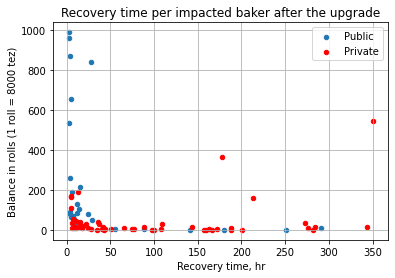

In [981]:
import pandas as pd
import numpy as np

ax1 = bakers_fixed_within_5cycles_public_df.plot(kind='scatter', x='time_to_fix_hours', y='rolls_upgrade_cycle', label='Public')    
ax2 = bakers_fixed_within_5cycles_private_df.plot(kind='scatter', x='time_to_fix_hours', y='rolls_upgrade_cycle', color='red', label='Private', ax=ax1)    

plt.xlabel('Recovery time, hr')
plt.ylabel('Balance in rolls (1 roll = 8000 tez)')
plt.title('Recovery time per impacted baker after the upgrade')
plt.grid(True)
plt.show()

In [1199]:
baker_rolls_list =[]
income_json = requests.get("https://api.tzstats.com/tables/income?&cycle=%s&columns=rolls&limit=90429" % cycle_upgrade)
income = income_json.json()
for baker_rolls in income:
    baker_rolls_list.append(baker_rolls[0])
num_rolls_cycle_upgrade = sum(baker_rolls_list)

In [1384]:
recovery_time_by_wealth = {'recovery_interval':[],'number_of_bakers':[],'number_of_rolls':[],'share_of_total_rolls':[]}

interval_dict = {'0-3 days':{ k:v for k,v in upgrade_results.items() 
                       if  (v['time_to_fix_hours']>2 and (v['time_to_fix_days']>=0 and v['time_to_fix_days']<=3) 
                            and v['n_slots_missed_due_to_upgrade_issues']>2)},
                '3-9 days':{ k:v for k,v in upgrade_results.items() 
                       if  (v['time_to_fix_hours']>2 and (v['time_to_fix_days']>3 and v['time_to_fix_days']<=9) 
                            and v['n_slots_missed_due_to_upgrade_issues']>2)},
                '9-15 days':{ k:v for k,v in upgrade_results.items() 
                       if  (v['time_to_fix_hours']>2 and (v['time_to_fix_days']>9 and v['time_to_fix_days']<=15) 
                            and v['n_slots_missed_due_to_upgrade_issues']>2)},
                 'Over 15 days':{ k:v for k,v in upgrade_results.items() 
                       if  v['time_to_fix_days']<0 and v['n_slots_missed_due_to_upgrade_issues']>2}}

for interval_k, interval_v in interval_dict.items():
    recovery_time_by_wealth['recovery_interval'].append(interval_k)
    recovery_time_by_wealth['number_of_bakers'].append(len(interval_v))
    recovery_time_by_wealth['number_of_rolls'].append(sum([ v['rolls_upgrade_cycle'] for v in interval_v.values()]))
    recovery_time_by_wealth['share_of_total_rolls'].append(sum([v['rolls_upgrade_cycle'] for v in interval_v.values()])/num_rolls_cycle_upgrade)

print(recovery_time_by_wealth)
recovery_time_by_wealth_impacted_bakers_df = pd.DataFrame(recovery_time_by_wealth)

total_impacted_bakers = sum(recovery_time_by_wealth['number_of_bakers'])
total_impacted_num_rolls = sum(recovery_time_by_wealth['number_of_rolls'])

print (total_impacted_bakers, total_impacted_num_rolls)

{'recovery_interval': ['0-3 days', '3-9 days', '9-15 days', 'Over 15 days'], 'number_of_bakers': [53, 19, 8, 26], 'number_of_rolls': [7558, 637, 635, 910], 'share_of_total_rolls': [0.09305933486831575, 0.007843185539973159, 0.007818560153662411, 0.011204550771390227]}
106 9740


In [1425]:
#Calculate total active bakers who had rights in cycle immidiately after the upgrade
baker_list = []
# Call Rigths API to retrive blocks stats within selected cycle
rights_json = requests.get("https://api.tzstats.com/tables/rights?cycle=%s&columns=address,cycle&limit=82182144" %cycle_upgrade)
rights = rights_json.json()
for right in rights:
    if right[0] not in baker_list:
        baker_list.append(right[0])
active_bakers = len(baker_list)

#Calculate the number of bakers who were not impacted by upgraide failures
upgrade_ready_bakers = active_bakers - total_impacted_bakers
upgrade_ready_num_rolls = num_rolls_cycle_upgrade - total_impacted_num_rolls

print(upgrade_ready_bakers)

329


In [1387]:
#Append upgrade ready number of bakers and rolls to recovery_time_by_wealth dictionary
recovery_time_by_wealth['recovery_interval'].append('Carthage ready')
recovery_time_by_wealth['number_of_bakers'].append(upgrade_ready_bakers)
recovery_time_by_wealth['number_of_rolls'].append(upgrade_ready_num_rolls)
recovery_time_by_wealth['share_of_total_rolls'].append(upgrade_ready_num_rolls/num_rolls_cycle_upgrade)
print(recovery_time_by_wealth)

{'recovery_interval': ['0-3 days', '3-9 days', '9-15 days', 'Over 15 days', 'Carthage ready'], 'number_of_bakers': [53, 19, 8, 26, 329], 'number_of_rolls': [7558, 637, 635, 910, 71477], 'share_of_total_rolls': [0.09305933486831575, 0.007843185539973159, 0.007818560153662411, 0.011204550771390227, 0.8800743686666584]}


In [1388]:
#Create DataFrame from recovery_time_by_wealth dictionary
recovery_time_by_wealth_active_bakers_df = pd.DataFrame(recovery_time_by_wealth)

In [1389]:
recovery_time_by_wealth_active_bakers_df.head(10)

,recovery_interval,number_of_bakers,number_of_rolls,share_of_total_rolls
0,0-3 days,53,7558,0.093059
1,3-9 days,19,637,0.007843
2,9-15 days,8,635,0.007819
3,Over 15 days,26,910,0.011205
4,Carthage ready,329,71477,0.880074


In [1445]:
target_row = 4
# Move target row to first element of list.
idx = [target_row] + [i for i in range(len(df)) if i != target_row]
recovery_time_by_wealth_active_bakers_df2 = recovery_time_by_wealth_active_bakers_df.iloc[idx]
recovery_time_by_wealth_active_bakers_df2.head()

,recovery_interval,number_of_bakers,number_of_rolls,share_of_total_rolls
4,Carthage ready,329,71477,0.880074
0,0-3 days,53,7558,0.093059
1,3-9 days,19,637,0.007843
2,9-15 days,8,635,0.007819
3,Over 15 days,26,910,0.011205


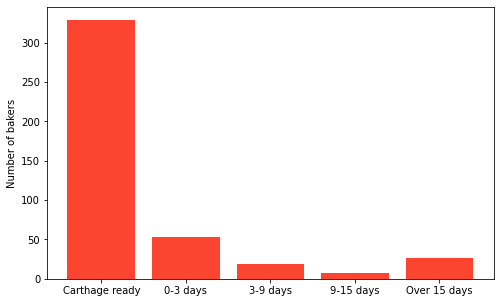

In [1446]:
df = pd.DataFrame({'x' : [1, 2, 3, 4, 5]})
x = df.x
#The below code will create two plots. The parameters that .subplot take are (row, column, no. of plots).
plt.subplot(1,1,1)
#This will create the bar graph for poulation
recovery_time = plt.bar(x, recovery_time_by_wealth_active_bakers_df2['number_of_bakers'], color='#fc4531')
plt.ylabel('Number of bakers')
plt.xticks(x, recovery_time_by_wealth_active_bakers_df2['recovery_interval'], rotation='horizontal')
plt.show()

In [1329]:
recovery_time_by_wealth_impacted_bakers_df.head(10)

,recovery_interval,number_of_bakers,number_of_rolls,share_of_total_rolls
0,0-3 days,53,7558,0.093059
1,3-9 days,19,637,0.007843
2,9-15 days,8,635,0.007819
3,Over 15 days,26,910,0.011205


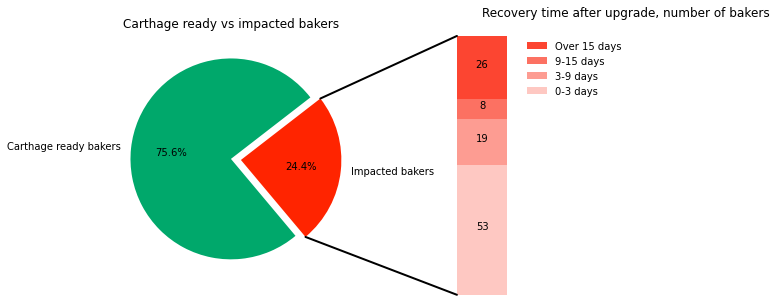

In [1391]:
#Pie Chart for recovery_time_by_wealth_df

import matplotlib.pyplot as plt
from matplotlib.patches import ConnectionPatch
import numpy as np


# make figure and assign axis objects
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 5))
fig.subplots_adjust(wspace=0)

# pie chart parameters
ratios = [total_impacted_bakers, upgrade_ready_bakers]
labels = ['Impacted bakers', 'Carthage ready bakers']
colors = ['#FF2400','#00A86B']
explode = [0.1, 0]
# rotate so that first wedge is split by the x-axis
#angle = -180 * ratios[0]
ax1.pie(ratios, autopct='%1.1f%%', startangle=310, colors=colors,
        labels=labels, explode=explode)
ax1.set_title('Carthage ready vs impacted bakers', horizontalalignment='center')

# bar chart parameters

xpos = 0
bottom = 0
ratios = recovery_time_by_wealth_impacted_bakers_df.number_of_bakers
width = 0.2
colors = ['#fec8c2','#fd9c92','#fc7162', '#fc4531']
labels = [recovery_time_by_wealth_impacted_bakers_df.number_of_bakers]


for j in range(len(ratios)):
    height = ratios[j]
    ax2.bar(xpos, height, width, bottom=bottom, color=colors[j])
    ypos = bottom + ax2.patches[j].get_height() / 2
    bottom += height
    ax2.text(xpos, ypos, (ax2.patches[j].get_height()),
             ha='center')


ax2.legend(recovery_time_by_wealth_impacted_bakers_df.recovery_interval,loc='upper right', bbox_to_anchor=(1.09, 0.8),
           labelspacing=-2.5, frameon=False)
ax2.set_title('Recovery time after upgrade, number of bakers', horizontalalignment='left')
ax2.axis('off')
ax2.set_xlim(- 2.5 * width, 2.5 * width)


# use ConnectionPatch to draw lines between the two plots
# get the wedge data
theta1, theta2 = ax1.patches[0].theta1, ax1.patches[0].theta2
center, r = ax1.patches[0].center, ax1.patches[0].r
bar_height = sum([item.get_height() for item in ax2.patches])

# draw top connecting line
x = r * np.cos(np.pi / 180 * theta2) + center[0]
y = r * np.sin(np.pi / 180 * theta2) + center[1]
con = ConnectionPatch(xyA=(-width / 2, bar_height), coordsA=ax2.transData,
                      xyB=(x, y), coordsB=ax1.transData)
con.set_color([0, 0, 0])
con.set_linewidth(2)
ax2.add_artist(con)

# draw bottom connecting line
x = r * np.cos(np.pi / 180 * theta1) + center[0]
y = r * np.sin(np.pi / 180 * theta1) + center[1]
con = ConnectionPatch(xyA=(-width / 2, 0), coordsA=ax2.transData,
                      xyB=(x, y), coordsB=ax1.transData)
con.set_color([0, 0, 0])
ax2.add_artist(con)
con.set_linewidth(2)

plt.show()



In [1331]:
recovery_time_by_wealth_active_bakers_df['share_of_total_rolls'] = recovery_time_by_wealth_active_bakers_df['share_of_total_rolls'].astype(float).round(2)
recovery_time_by_wealth_impacted_bakers_df.head()

,recovery_interval,number_of_bakers,number_of_rolls,share_of_total_rolls
0,0-3 days,53,7558,0.093059
1,3-9 days,19,637,0.007843
2,9-15 days,8,635,0.007819
3,Over 15 days,26,910,0.011205


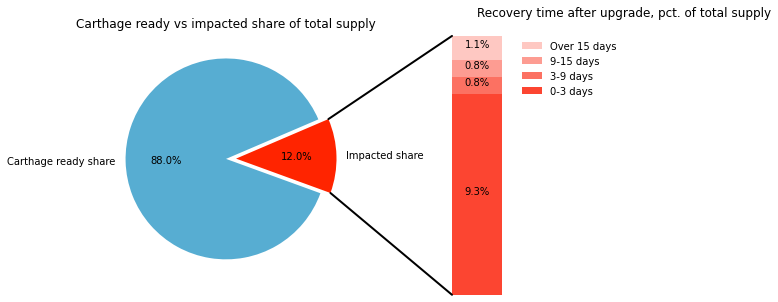

In [1382]:
#Pie Chart for recovery_time_by_wealth_df

import matplotlib.pyplot as plt
from matplotlib.patches import ConnectionPatch
import numpy as np

# make figure and assign axis objects
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 5))
fig.subplots_adjust(wspace=0)

# pie chart parameters
ratios = [total_impacted_num_rolls, upgrade_ready_num_rolls]
labels = ['Impacted share', 'Carthage ready share']
colors = ['#FF2400','#57ADD2']
explode = [0.1, 0]
# rotate so that first wedge is split by the x-axis
#angle = -180 * ratios[0]
ax1.pie(ratios, autopct='%1.1f%%', startangle=340, colors=colors,
        labels=labels, explode=explode)
ax1.set_title('Carthage ready vs impacted share of total supply', horizontalalignment='center')


# bar chart parameters

xpos = 0
bottom = 0
ratios = recovery_time_by_wealth_impacted_bakers_df.share_of_total_rolls
width = 0.2
colors = ['#fc4531','#fc7162','#fd9c92','#fec8c2']

for j in range(len(ratios)):
    height = ratios[j]
    ax2.bar(xpos, height, width, bottom=bottom, color=colors[j])
    ypos = bottom + ax2.patches[j].get_height() / 2
    bottom += height
    ax2.text(xpos, ypos, "%0.1f%%" % (ax2.patches[j].get_height() * 100),
             ha='center')

ax2.legend(recovery_time_by_wealth_impacted_bakers_df.recovery_interval,loc='upper right', bbox_to_anchor=(1.09, 0.8),
           labelspacing=-2.5, frameon=False)
ax2.set_title('Recovery time after upgrade, pct. of total supply', horizontalalignment='left')
ax2.axis('off')
ax2.set_xlim(- 2.5 * width, 2.5 * width)

# use ConnectionPatch to draw lines between the two plots
# get the wedge data
theta1, theta2 = ax1.patches[0].theta1, ax1.patches[0].theta2
center, r = ax1.patches[0].center, ax1.patches[0].r
bar_height = sum([item.get_height() for item in ax2.patches])

# draw top connecting line
x = r * np.cos(np.pi / 180 * theta2) + center[0]
y = r * np.sin(np.pi / 180 * theta2) + center[1]
con = ConnectionPatch(xyA=(-width / 2, bar_height), coordsA=ax2.transData,
                      xyB=(x, y), coordsB=ax1.transData)
con.set_color([0, 0, 0])
con.set_linewidth(2)
ax2.add_artist(con)

# draw bottom connecting line
x = r * np.cos(np.pi / 180 * theta1) + center[0]
y = r * np.sin(np.pi / 180 * theta1) + center[1]
con = ConnectionPatch(xyA=(-width / 2, 0), coordsA=ax2.transData,
                      xyB=(x, y), coordsB=ax1.transData)
con.set_color([0, 0, 0])
ax2.add_artist(con)
con.set_linewidth(2)

plt.show()

In [1346]:
print('start')
income_upgrade_dict = {'cycle':[],
                'n_blocks_lost':[],
                'n_slots_missed':[],
                'n_baking_rights':[],
                'n_endorsing_rights':[],
                'missed_baking_income':[],
                'missed_endorsing_income':[]
                }

for cycle in cycle_upgrade_range:
    income_upgrade_dict['cycle'].append(cycle)
    
    for metric in ['n_blocks_lost', 'n_slots_missed','n_baking_rights','n_endorsing_rights','missed_baking_income','missed_endorsing_income']:
        metric_sum = sum([(baker_v[cycle][metric] if cycle in baker_v else 0) for baker_v in income_dict.values()])
        income_upgrade_dict[metric].append(metric_sum)
    

start


In [641]:
income_upgrade_dict_df = pd.DataFrame(income_upgrade_dict)
income_upgrade_dict_df.head(10)

,cycle,n_blocks_lost,n_slots_missed,n_baking_rights,n_endorsing_rights,missed_baking_income,missed_endorsing_income
0,204,130,3332,4096,131072,2080.0,6664.00
1,205,96,2981,4096,131072,1536.0,5962.00
2,206,97,3068,4096,131072,1552.0,6136.00
3,207,140,3930,4096,131072,2240.0,7860.00
4,208,258,7873,4096,131072,10320.0,9841.25
5,209,199,6304,4096,131072,7960.0,7880.00
6,210,164,5203,4096,131072,6560.0,6503.75
7,211,139,4287,4096,131072,5560.0,5358.75
8,212,120,3884,4096,131072,4800.0,4855.00


In [646]:
income_upgrade_dict_df = pd.DataFrame(income_upgrade_dict)
income_upgrade_dict_df.head(10)

,cycle,n_blocks_lost,n_slots_missed,n_baking_rights,n_endorsing_rights,missed_baking_income,missed_endorsing_income
0,204,130,3332,4096,131072,2080.0,6664.00
1,205,96,2981,4096,131072,1536.0,5962.00
2,206,97,3068,4096,131072,1552.0,6136.00
3,207,140,3930,4096,131072,2240.0,7860.00
4,208,258,7873,4096,131072,10320.0,9841.25
5,209,199,6304,4096,131072,7960.0,7880.00
6,210,164,5203,4096,131072,6560.0,6503.75
7,211,139,4287,4096,131072,5560.0,5358.75
8,212,120,3884,4096,131072,4800.0,4855.00


(1000.0, 11000.0)

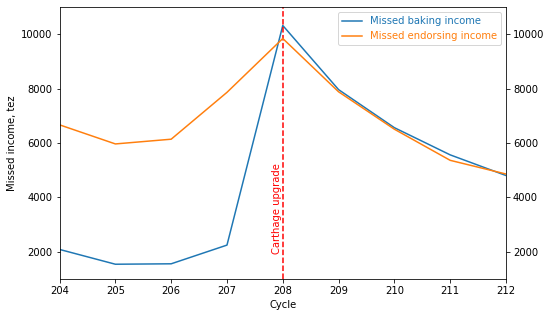

In [1452]:
from mpl_toolkits.axes_grid1 import host_subplot
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (8,5)

host = host_subplot(111)
par = host.twinx()
host.set_xlabel("Cycle")
host.set_ylabel("Missed income, tez")

p1, = host.plot(income_upgrade_dict_df.cycle, income_upgrade_dict_df.missed_baking_income, label="Missed baking income")
p2, = par.plot(income_upgrade_dict_df.cycle, income_upgrade_dict_df.missed_endorsing_income, label="Missed endorsing income")

leg = plt.legend()

host.yaxis.get_label()
leg.texts[0].set_color(p1.get_color())

x_line_annotation = 208
x_text_annotation = 207.80
host.axvline(x=x_line_annotation, linestyle='dashed', alpha=1, color='red')
host.text(x=x_text_annotation, y=2000, s='Carthage upgrade', alpha=1, rotation='vertical', color='red')

par.yaxis.get_label()
leg.texts[1].set_color(p2.get_color())
plt.xlim(left=205,right=212)
host.set_xlim((204,212)) 
host.set_ylim((1000, 11000))
par.set_ylim((1000, 11000))

(204.0, 212.0)

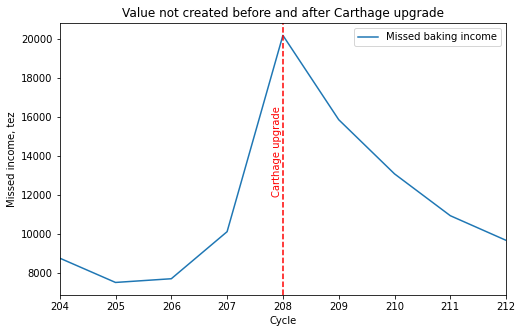

In [1461]:
from mpl_toolkits.axes_grid1 import host_subplot
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (8,5)

host = host_subplot(111)
host.set_xlabel("Cycle")
host.set_ylabel("Missed income, tez")

p1, = host.plot(income_upgrade_dict_df.cycle, income_upgrade_dict_df.missed_baking_income+income_upgrade_dict_df.missed_endorsing_income, label="Missed baking income")

leg = plt.legend()

host.yaxis.get_label()
host.set_title('Value not created before and after Carthage upgrade')
x_line_annotation = 208
x_text_annotation = 207.80
host.axvline(x=x_line_annotation, linestyle='dashed', alpha=1, color='red')
host.text(x=x_text_annotation, y=12000, s='Carthage upgrade', alpha=1, rotation='vertical', color='red')

par.yaxis.get_label()
plt.xlim(left=205,right=212)
host.set_xlim((204,212)) 

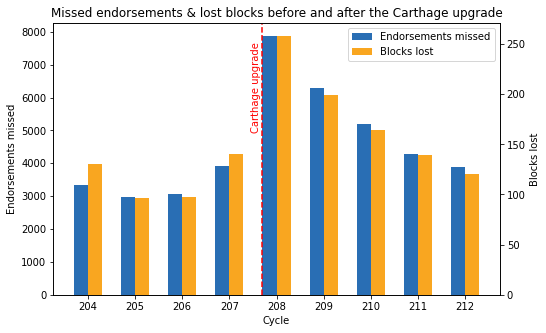

In [756]:
plt.rcParams["figure.figsize"] = (8,5)
x = income_upgrade_dict_df['cycle']
ax1 = plt.subplot(1,1,1)
w = 0.3
#plt.xticks(), will label the bars on x axis with the respective cycle IDs.
plt.xticks(x + w /2, income_upgrade_dict_df['cycle'])
#generate bars for Y-left axis for shared X axis
slots =ax1.bar(x, income_upgrade_dict_df['n_slots_missed'], width=w, color='#296EB4', align='center')
#The trick is to use two different axes that share the same x axis, we have used ax1.twinx() method.
ax2 = ax1.twinx()
#generate bars for Y-right axis for shared X axis
blocks =ax2.bar(x + w, income_upgrade_dict_df['n_blocks_lost'], width=w,color='#F9A620',align='center')
#Set the Graph title.
plt.title('Missed endorsements & lost blocks before and after the Carthage upgrade')
#Set the X axis label.
ax1.set_xlabel('Cycle')
#Set the Y-left axis label.
ax1.set_ylabel('Endorsements missed')
#Set the Y-right axis label.
ax2.set_ylabel('Blocks lost')
#To set the legend on the plot we have used plt.legend()
plt.legend([slots, blocks],['Endorsements missed', 'Blocks lost'])

x_line_annotation = 207.85
x_text_annotation = 207.60
ax1.axvline(x=x_line_annotation, linestyle='dashed', alpha=1, color='red')
ax1.text(x=x_text_annotation, y=5000, s='Carthage upgrade', alpha=1, rotation='vertical', color='red')

#To show the plot finally we have used plt.show().
plt.show()

In [873]:
# Calculate the number of bakers impacted by upgrade failures
impacted_bakers = upgrade_results_table.address.count()

#Calculate total active bakers who had rights in cycle immidiately after the upgrade
baker_list = []
# Call Rigths API to retrive blocks stats within selected cycle
rights_json = requests.get("https://api.tzstats.com/tables/rights?cycle=%s&columns=address,cycle&limit=82182144" %cycle_upgrade)
rights = rights_json.json()
for right in rights:
    if right[0] not in baker_list:
        baker_list.append(right[0])
active_bakers = len(baker_list)

#Calculate the number of bakers who were not impacted by upgraide failures
not_impacted_bakers = active_bakers - impacted_bakers

In [1381]:
bakers_cycle_after_upgrade_pn = {'active_bakers':[active_bakers,(active_bakers/active_bakers*100)],
                                 'impacted_bakers':[impacted_bakers,(impacted_bakers/active_bakers*100)],
                                 'not_impacted_bakers':[not_impacted_bakers, (not_impacted_bakers/active_bakers*100)]}
bakers_cycle_after_upgrade_df = pd.DataFrame(bakers_cycle_after_upgrade_pn)
bakers_cycle_after_upgrade_df.head()

,active_bakers,impacted_bakers,not_impacted_bakers
0,435.0,123.000000,312.000000
1,100.0,28.275862,71.724138
